In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import pandas as pd
import os
from keras import layers

from data_processing import *
from training_utils import *



2024-04-13 13:15:51.135035: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 13:15:51.170221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
MODEL_WEIGHTS_PATH="local_runs/L_size_model/checkpoints/weights_checkpoint.h5"
MODEL_CONFIG_PATH="local_runs/L_size_model/trial_config.json"
TOKENIZER_PATH="local_runs/L_size_model/tokenizer.keras"

In [3]:
with open(MODEL_CONFIG_PATH, "r") as f:
    CONFIG = json.load(f)
    

In [4]:
CONFIG

{'TIMESTAMP': '04-13-12:23',
 'DATA_PATH': 'data/flickr30k_images/',
 'IMAGES_PATH': 'data/flickr30k_images/flickr30k_images/',
 'IMAGE_SIZE': [224, 224],
 'VAL_FRACTION': 0.05,
 'SEQ_LENGTH': 36,
 'VOCAB_SIZE': 10000,
 'BATCH_SIZE': 128,
 'STRIP_CHARS': '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~',
 'EPOCHS': 10,
 'EMBED_DIM': 1028,
 'FF_DIM': 512,
 'ENC_HEADS': 4,
 'DEC_HEADS': 4,
 'ARTIFACT_DIR': './local_runs/L_size_model',
 'LR': 0.0001}

In [5]:
model = load_trained_model_weights(MODEL_WEIGHTS_PATH, CONFIG)

2024-04-13 13:15:56.258472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 13:15:56.290337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 13:15:56.290549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
model.summary()

Model: "image_captioning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 49, 1280)          6575239   
                                                                 
 transformer_encoder_block   multiple                  18243392  
 (TransformerEncoderBlock)                                       
                                                                 
 transformer_decoder_block   multiple                  55511204  
 (TransformerDecoderBlock)                                       
                                                                 
Total params: 80329839 (306.43 MB)
Trainable params: 73754596 (281.35 MB)
Non-trainable params: 6575243 (25.08 MB)
_________________________________________________________________


In [7]:
tokenizer = load_tokenizer(TOKENIZER_PATH)

In [8]:
caption_model = model

In [9]:
val_captionings_df = pd.read_csv("splits/val_captions.csv")

vocab = tokenizer.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = CONFIG["SEQ_LENGTH"] - 1
valid_images = val_captionings_df.iloc[1: 1000]["image_name"].to_list()

import matplotlib.pyplot as plt
def generate_caption():
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img, CONFIG["IMAGE_SIZE"])
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.figure(figsize=(6, 6))
    plt.imshow(img / 255.0)
    

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    
    img = caption_model.cnn_model(img)

    
    
    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = tokenizer([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "end":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace("end", "").strip()
    print("Predicted Caption: ", decoded_caption)

    plt.show()

Predicted Caption:  a young boy in a blue shirt is playing soccer


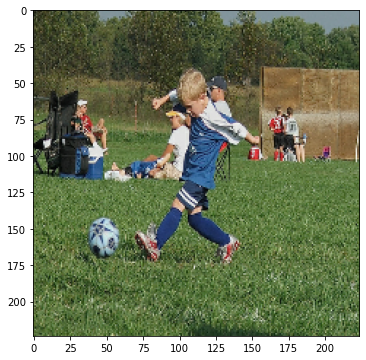

Predicted Caption:  a man in a white shirt and black pants is standing in front of a red wall


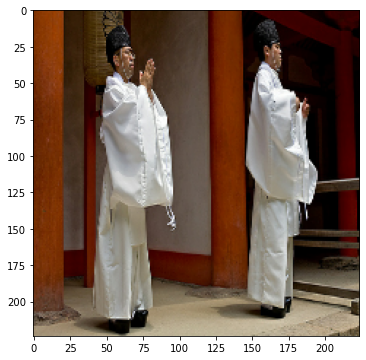

Predicted Caption:  a black dog is running through a field


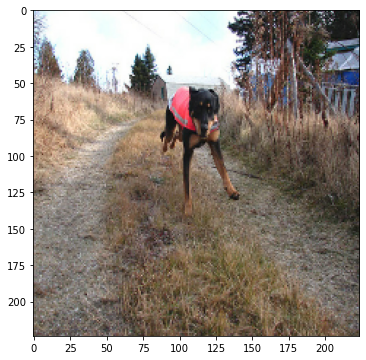

Predicted Caption:  a woman is sitting at a table with a red and white shirt


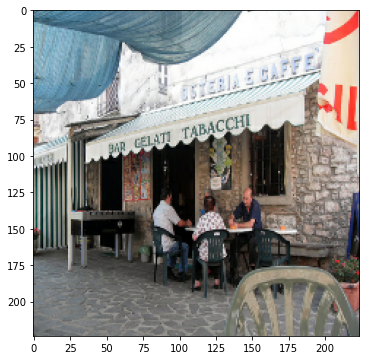

Predicted Caption:  a group of people are standing outside of a restaurant


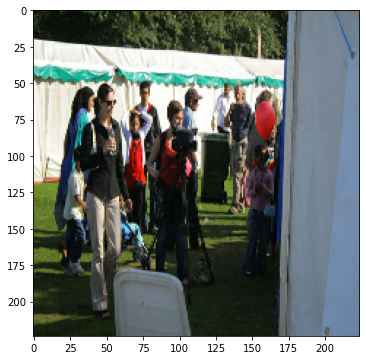

Predicted Caption:  a man in a red and black shirt is riding a bike


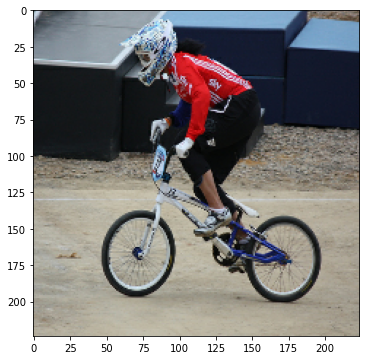

Predicted Caption:  a baseball player is trying to catch a ball


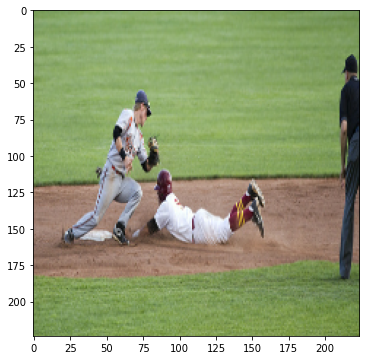

Predicted Caption:  a man in a blue jacket is walking down the street


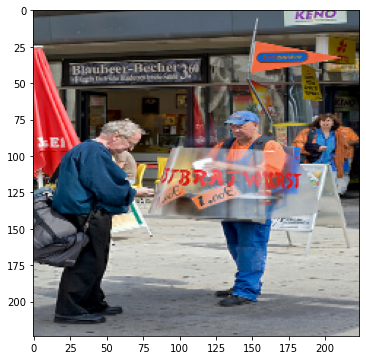

Predicted Caption:  a group of people are walking down a street


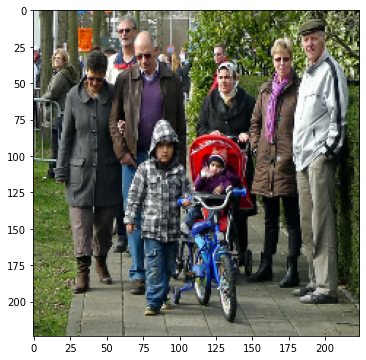

Predicted Caption:  a woman in a black shirt and a woman in a black shirt is walking down the street


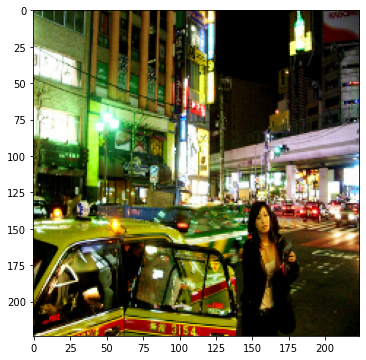

Predicted Caption:  a man in a red shirt is doing a trick on a ladder


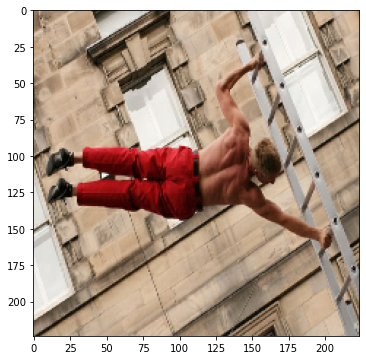

Predicted Caption:  a group of children are jumping in the air


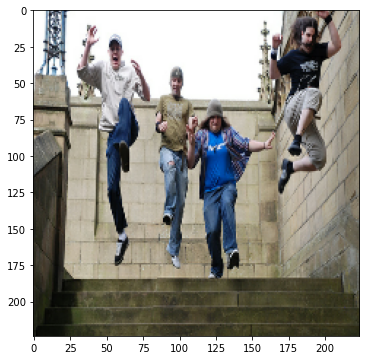

Predicted Caption:  a man and a woman are standing in a field


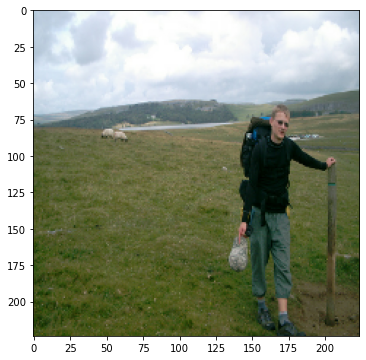

Predicted Caption:  a young boy is playing with a large stick


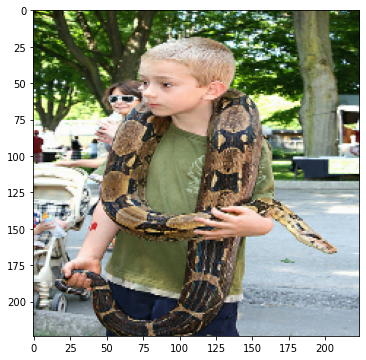

Predicted Caption:  a woman in a white shirt and sunglasses is sitting on a bench


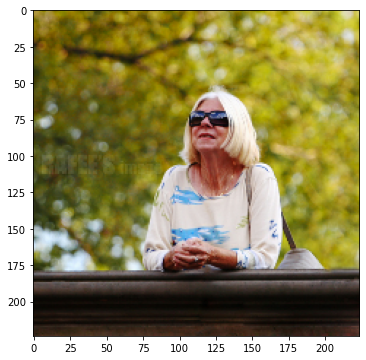

Predicted Caption:  a man in a red helmet is riding a motorcycle


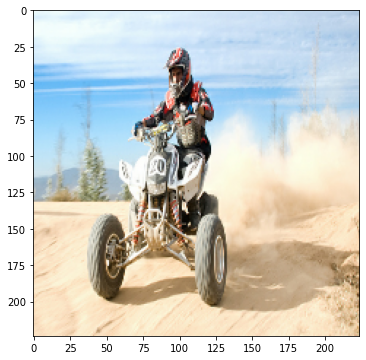

Predicted Caption:  a man in a red shirt and black pants is skateboarding on a ramp


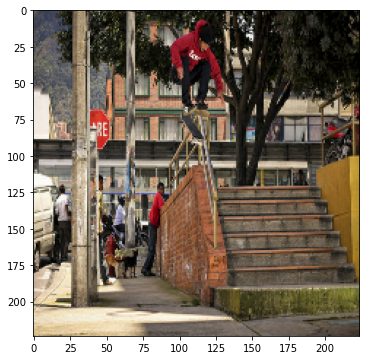

Predicted Caption:  a man in a blue shirt and a woman in a white shirt is working on a wooden structure


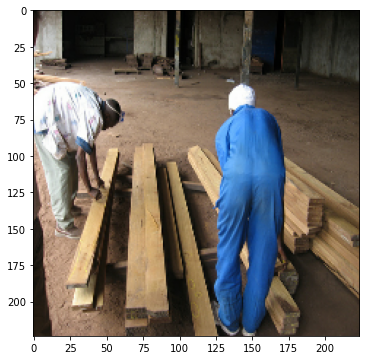

Predicted Caption:  a man is skiing down a snowy mountain


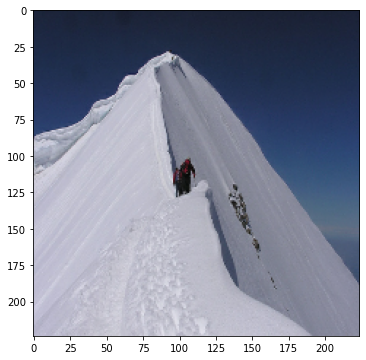

Predicted Caption:  a woman in a pink shirt and a woman in a pink shirt is sitting on a bench


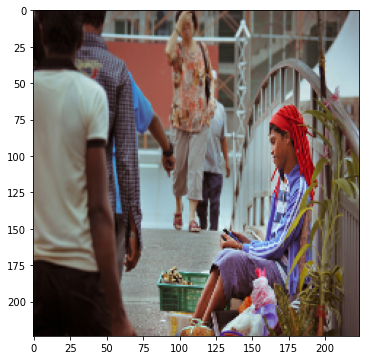

In [12]:
N_TO_GENERATE = 20

for _ in range(N_TO_GENERATE):
    generate_caption()